In [1]:
for i in range(0,1):
    import pybamm as pybamm
    import pandas as pd   
    import numpy as np
    import os
    import matplotlib.pyplot as plt
    from scipy.io import savemat,loadmat
    from pybamm import constants,exp,sqrt
    import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False

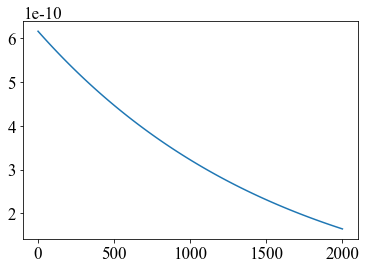

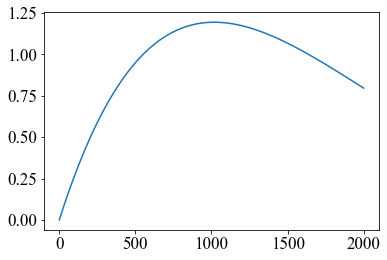

<AxesSubplot:>

In [2]:
Para_0=pybamm.ParameterValues("Xu2019");
c_e = pybamm.linspace(0, 2000, 100)
D_e = Para_0["Electrolyte diffusivity [m2.s-1]"]
pybamm.plot(c_e, D_e(c_e, 298.15))
sigma_e = Para_0['Electrolyte conductivity [S.m-1]']
pybamm.plot(c_e, sigma_e(c_e, 298.15))

In [3]:
# Define electrolyte diffusivity and conductivity
def electrolyte_diffusivity_Nyman2008(c_e, T):
    D_c_e = 8.794e-11 * (c_e / 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10
    return D_c_e    
def electrolyte_conductivity_Nyman2008(c_e, T):
    sigma_e = (0.1297 * (c_e / 1000) ** 3 - 2.51 * (c_e / 1000) ** 1.5 + 3.329 * (c_e / 1000))
    return sigma_e

def electrolyte_conductivity_Valoen2005(c_e, T):   # valid concentration: 0~4000 mol/m3
    sigma_e = 0.1 * (-10.5 + 0.668*(1e-3*c_e) + 0.494*(1e-6*c_e**2) + 0.074*T - 0.0178*(1e-3*c_e)*T - 8.86e-4*(1e-6*c_e**2)*T - 6.96e-5*T**2 + 2.8E-5*(1E-3*c_e)*T**2 ) **2 * (1e-3*c_e)
    return sigma_e
def electrolyte_diffusivity_Valoen2005(c_e, T):
    D_c_e = 1e-4 * 10**(-4.43 - 54/(T - 229 - 0.005*c_e) - 2.2e-4 * c_e   )
    return D_c_e

def electrolyte_conductivity_Ecker2015(c_e, T):
    # mol/m^3 to mol/l
    cm = 1e-3 * c_e
    # value at T = 296K
    sigma_e_296 = 0.2667 * cm ** 3 - 1.2983 * cm ** 2 + 1.7919 * cm + 0.1726
    # Add temperature dependence
    E_k_e = 1.71e4
    C = 296 * exp(E_k_e / (constants.R * 296))
    sigma_e = C * sigma_e_296 * exp(-E_k_e / (constants.R * T)) / T
    return sigma_e.value
def electrolyte_diffusivity_Ecker2015(c_e, T):
    # mol/m^3 to mol/l
    cm = 1e-3 * c_e
    # value at T = 296K
    sigma_e_296 = 0.2667 * cm ** 3 - 1.2983 * cm ** 2 + 1.7919 * cm + 0.1726
    # add temperature dependence
    E_k_e = 1.71e4
    C = 296 * exp(E_k_e / (constants.R * 296))
    sigma_e = C * sigma_e_296 * exp(-E_k_e / (constants.R * T)) / T
    D_c_e = (constants.k_b / (constants.F * constants.q_e)) * sigma_e * T / c_e
    return D_c_e.value

def electrolyte_conductivity_Ding2001(c_e, c_EC,  T):
    # c_e is lithium ion concentration in electrolyte in mol/m3, need to change to mol/kg
    # also be careful that T here is deg, while others are K
    rho_electrolyte = 1300 # in kg/m3
    c_e_kg = c_e / rho_electrolyte     # in mol/kg 
    M_LiPF6 = 151.905/1000  # kg/mol
    M_EC = 88.062/1000  # kg/mol
    M_EMC = 104.104/1000 # kg/mol
    x_EC = 1 / (1+ ( rho_electrolyte - c_e*M_LiPF6 - c_EC*M_EC  )/M_EMC/c_EC   )
    kai = -3.37115 + 12.5608*c_e_kg - 7.89593*c_e_kg**2 + 3.51922*c_e_kg**3-1.15471*c_e_kg**4 +18.1863*x_EC - 6.22756*c_e_kg*x_EC - 13.6916*c_e_kg**2*x_EC +8.43904*c_e_kg**3*x_EC - 7.83732*x_EC**2 + 19.607*c_e_kg*x_EC**2  - 18.4529*c_e_kg**2*x_EC**2 -30.6369*x_EC**3 + 29.2*c_e_kg*x_EC**3 - 0.0429918*T + 0.180877*c_e_kg*T -0.0836202*c_e_kg**2*T + 0.0230098*c_e_kg**3*T + 0.195946*T*x_EC +0.0676686*c_e_kg*x_EC*T - 0.14134*c_e_kg**2*x_EC*T + 0.147429*x_EC**2*T  +0.173059*c_e_kg*x_EC**2*T - 0.51634*x_EC**3*T - 0.000223097*T**2 +0.000111233*c_e_kg*T**2 + 0.0000495286*c_e_kg**2*T**2  +0.000952777*x_EC*T**2 + 0.00117334 *c_e_kg*x_EC*T**2-0.000619157*x_EC**2*T**2 - 3.46897E-7*T**3 - 2.75041E-6*c_e_kg*T**3 -5.57653E-6*x_EC*T**3 
    return kai / 10 

In [4]:
from numpy import tanh,exp
def electrolyte_conductivity_Valoen2005Constant_ECtanh1000_1(c_e,c_EC, T):# Mark Ruihe change
    # mol/m3 to molar
    T = T + 273.15;
    c_e = c_e / 1000
    sigma = (c_e <= 4.5) * (
        (1e-3 / 1e-2) * (
        c_e
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + c_e * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + c_e ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    )) + (c_e > 4.5) *  (
        (1e-3 / 1e-2) * (
        4.5
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + 4.5 * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + 4.5 ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    ))
    coff = 1
    ratio = ( (1-coff)+ coff/2 + coff/2 *  tanh((c_EC-4500*0.5)/1000))
    return sigma*ratio

def electrolyte_conductivity_Valoen2005Constant_ECtanh500_1(c_e,c_EC, T):# Mark Ruihe change
    T = T + 273.15;
    # mol/m3 to molar
    c_e = c_e / 1000
    sigma = (c_e <= 4.5) * (
        (1e-3 / 1e-2) * (
        c_e
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + c_e * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + c_e ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    )) + (c_e > 4.5) *  (
        (1e-3 / 1e-2) * (
        4.5
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + 4.5 * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + 4.5 ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    ))
    coff = 1
    ratio = ( (1-coff)+ coff/2 + coff/2 *  tanh((c_EC-4500*0.5)/500))
    return sigma*ratio


def electrolyte_conductivity_Ding2001(c_e, c_EC,  T):
    # c_e is lithium ion concentration in electrolyte in mol/m3, need to change to mol/kg
    # also be careful that T here is deg, while others are K
    rho_electrolyte = 1300 # in kg/m3
    c_e_kg = c_e / rho_electrolyte     # in mol/kg 
    M_LiPF6 = 151.905/1000  # kg/mol
    M_EC = 88.062/1000  # kg/mol
    M_EMC = 104.104/1000 # kg/mol
    x_EC = 1 / (1+ ( rho_electrolyte - c_e*M_LiPF6 - c_EC*M_EC  )/M_EMC/c_EC   )
    kai = -3.37115 + 12.5608*c_e_kg - 7.89593*c_e_kg**2 + 3.51922*c_e_kg**3-1.15471*c_e_kg**4 +18.1863*x_EC - 6.22756*c_e_kg*x_EC - 13.6916*c_e_kg**2*x_EC +8.43904*c_e_kg**3*x_EC - 7.83732*x_EC**2 + 19.607*c_e_kg*x_EC**2  - 18.4529*c_e_kg**2*x_EC**2 -30.6369*x_EC**3 + 29.2*c_e_kg*x_EC**3 - 0.0429918*T + 0.180877*c_e_kg*T -0.0836202*c_e_kg**2*T + 0.0230098*c_e_kg**3*T + 0.195946*T*x_EC +0.0676686*c_e_kg*x_EC*T - 0.14134*c_e_kg**2*x_EC*T + 0.147429*x_EC**2*T  +0.173059*c_e_kg*x_EC**2*T - 0.51634*x_EC**3*T - 0.000223097*T**2 +0.000111233*c_e_kg*T**2 + 0.0000495286*c_e_kg**2*T**2  +0.000952777*x_EC*T**2 + 0.00117334 *c_e_kg*x_EC*T**2-0.000619157*x_EC**2*T**2 - 3.46897E-7*T**3 - 2.75041E-6*c_e_kg*T**3 -5.57653E-6*x_EC*T**3 
    return kai / 10 

def electrolyte_conductivity_Valoen2005Constant_wEC_Haya(c_e,c_EC, T):
    T = T + 273.15;
    # mol/m3 to molar
    c_e = c_e / 1000
    sigma = (c_e <= 4.5) * (
        (1e-3 / 1e-2) * (
        c_e
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + c_e * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + c_e ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    )) + (c_e > 4.5) *  (
        (1e-3 / 1e-2) * (
        4.5
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + 4.5 * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + 4.5 ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    ))
    a=1.092; b=-6.497e-6; c=-0.7877; d=-0.0004808
    ratio= (
        a*exp(b*c_EC)+c*exp(d*c_EC) )
    return sigma*ratio

def electrolyte_conductivity_Valoen2005Constant(c_e,c_EC, T):# Mark Ruihe change
    T = T + 273.15;
    # mol/m3 to molar
    c_e = c_e / 1000
    sigma = (c_e <= 4.5) * (
        (1e-3 / 1e-2) * (
        c_e
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + c_e * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + c_e ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    )) + (c_e > 4.5) *  (
        (1e-3 / 1e-2) * (
        4.5
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + 4.5 * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + 4.5 ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    ))
    # mS/cm to S/m
    return sigma

def electrolyte_conductivity_Andrew2022(x,y, T):# x:Li+,y:ec
    p00 =     -0.2524;
    p10 =    0.001402;
    p01 =   0.0001142 ;
    p20 =  -5.379e-07  ;
    p11 =  -1.399e-08 ;
    p02 =  -8.137e-09  ;
    kai  = p00 + p10*x + p01*y + p20*x*x + p11*x*y + p02*y*y
    return kai


In [14]:
N = 200;
c_e = np.linspace(0, 3000, N)
c_EC = np.linspace(3e3, 1e4, N)
kai_Valoen2005Constant_ECtanh1000_1= np.full([N,N],1.0)
kai_Valoen2005Constant_ECtanh500_1 = np.full([N,N],1.0)
kai_Valoen2005Constant_wEC_Haya    = np.full([N,N],1.0)
kai_Valoen2005Constant             = np.full([N,N],1.0)
kai_Andrew2022                     = np.full([N,N],1.0)
kai_Ding2001                       = np.full([N,N],1.0)

for i in range(0,N):
    for j in range(0,N):
        #print(c_e[i],c_EC[j],electrolyte_conductivity_Andrew2022(c_e[i],c_EC[j],25))
        kai_Andrew2022[i,j] = electrolyte_conductivity_Andrew2022(c_e[i],c_EC[j],25)
        kai_Valoen2005Constant_ECtanh1000_1[i,j]= electrolyte_conductivity_Valoen2005Constant_ECtanh1000_1(c_e[i],c_EC[j],25)
        kai_Valoen2005Constant_ECtanh500_1 [i,j]= electrolyte_conductivity_Valoen2005Constant_ECtanh500_1(c_e[i],c_EC[j],25)
        kai_Valoen2005Constant_wEC_Haya    [i,j]= electrolyte_conductivity_Valoen2005Constant_wEC_Haya(c_e[i],c_EC[j],25)
        kai_Valoen2005Constant             [i,j]= electrolyte_conductivity_Valoen2005Constant(c_e[i],c_EC[j],25)
        kai_Ding2001                       [i,j]= electrolyte_conductivity_Ding2001(c_e[i],c_EC[j],25)

Kai_All =[
    kai_Andrew2022,kai_Ding2001,
    kai_Valoen2005Constant,kai_Valoen2005Constant_wEC_Haya,
    kai_Valoen2005Constant_ECtanh500_1,kai_Valoen2005Constant_ECtanh1000_1
]
Title_All =[
    "Andrew_2022","Ding_2001",
    "Valoen_Constant","Valoen_Haya",
    "Valoen_tanh500","Valoen_tanh1000"
]


In [6]:
a=1.092; b=-6.497e-6; c=-0.7877; d=-0.0004808
c_EC_i = 9000; coff = 1
print(
    a*exp(b*c_EC_i)+c*exp(d*c_EC_i) )
print(
     (1-coff)+ coff/2 + coff/2 *  tanh((c_EC_i-4500*0.5)/500))
#print(type(Kai_All[kk]))
print(electrolyte_conductivity_Valoen2005Constant_ECtanh1000_1(2000,9000, 25))
print(electrolyte_conductivity_Valoen2005Constant_ECtanh1000_1(2000,6000, 25))
print(electrolyte_conductivity_Valoen2005Constant_ECtanh1000_1(2000,10000, 25))
print(electrolyte_conductivity_Valoen2005Constant_ECtanh1000_1(2000,2000, 25))

1.0195772878886011
0.9999999999981204
0.796295886572749
0.7958568023036001
0.7962968305176039
0.3006344937349136


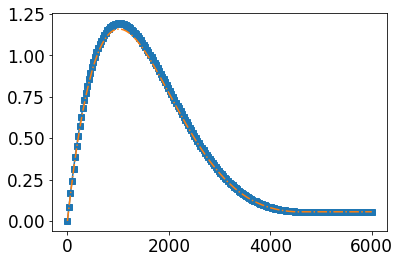

In [13]:
plt.plot(c_e,electrolyte_conductivity_Valoen2005Constant_ECtanh1000_1(c_e, 10000,25),"-s",)
#plt.plot(c_e,electrolyte_conductivity_Valoen2005Constant_ECtanh1000_1(c_e, 4000,25),"-o",)
plt.plot(c_e,electrolyte_conductivity_Valoen2005Constant_ECtanh1000_1(c_e, 4000,25),"-.",)
#plt.plot(c_e,electrolyte_conductivity_Valoen2005Constant_ECtanh1000_1(c_e, 1e4,25),"--",)

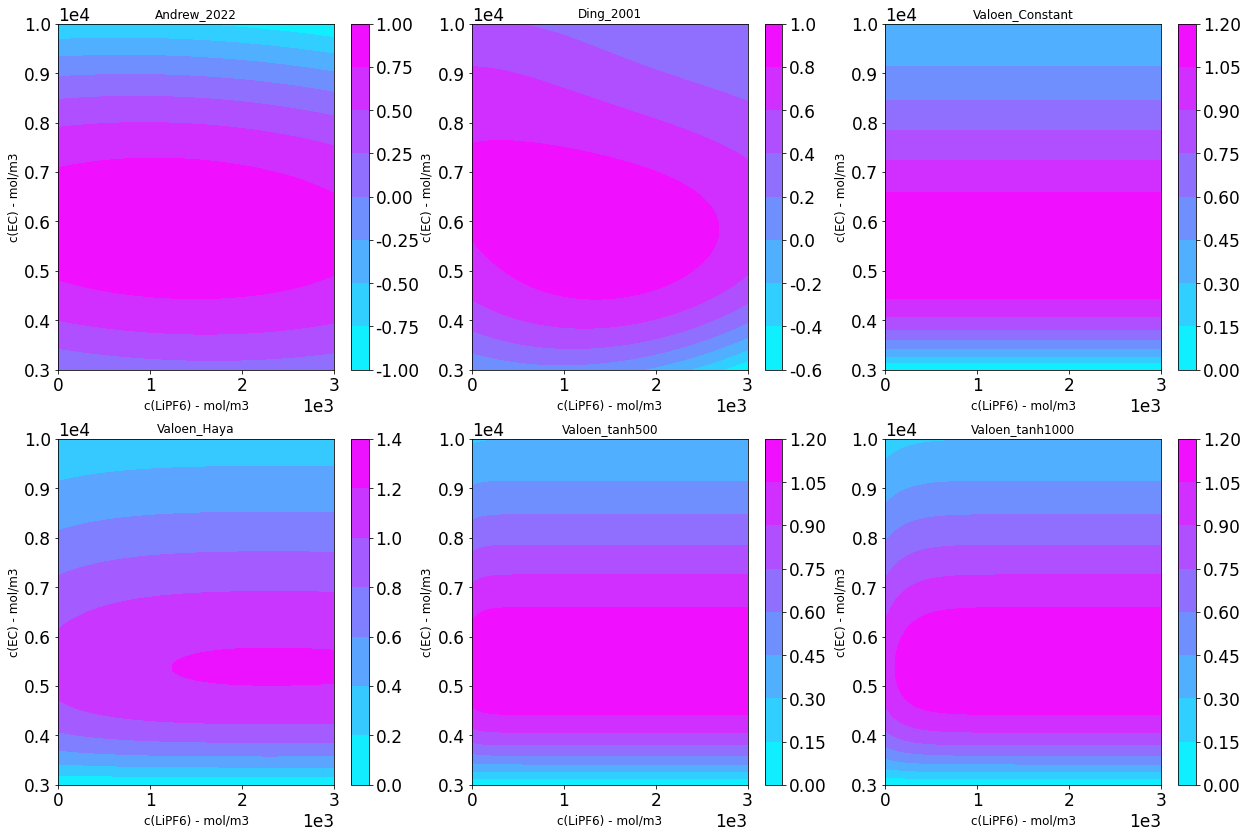

In [15]:
fs = 12
font = {'family' : 'DejaVu Sans',
        'size'   : fs}
mpl.rc('font', **font)
fig, ax = plt.subplots(2, 3, figsize=(21,14))
kk=0
for i in range(0,2):
    for j in range(0,3):
        cs = ax[i,j].contourf(c_e, c_EC, Kai_All[kk], cmap="cool",)
        ax[i,j].set_title(Title_All[kk], fontdict={'family':'DejaVu Sans','size':fs})
        kk += 1;
        ax[i,j].set_xlabel("c(LiPF6) - mol/m3",   fontdict={'family':'DejaVu Sans','size':fs})
        ax[i,j].set_ylabel("c(EC) - mol/m3",   fontdict={'family':'DejaVu Sans','size':fs})
        ax[i,j].ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
        ax[i,j].ticklabel_format(style='sci', scilimits=(-1,2), axis='x')
        fig.colorbar(cs, ax=ax[i,j])
        
        #ax[i,j].locator_params(nbins=4)

plt.show()

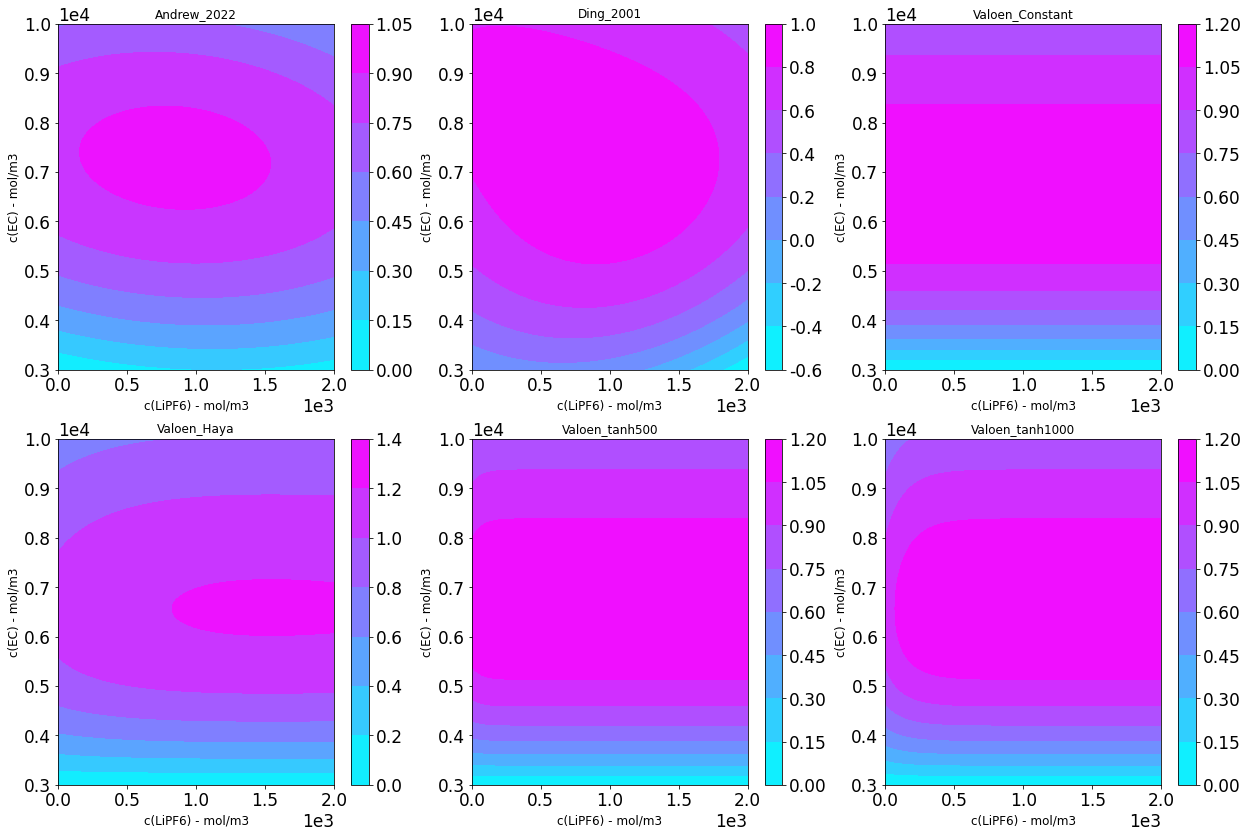

In [20]:
N = 200;
c_e = np.linspace(0, 2000, N)
c_EC = np.linspace(3000, 1e4, N)
kai_Valoen2005Constant_ECtanh1000_1= np.full([N,N],1.0)
kai_Valoen2005Constant_ECtanh500_1 = np.full([N,N],1.0)
kai_Valoen2005Constant_wEC_Haya    = np.full([N,N],1.0)
kai_Valoen2005Constant             = np.full([N,N],1.0)
kai_Andrew2022                     = np.full([N,N],1.0)
kai_Ding2001                       = np.full([N,N],1.0)

for i in range(0,N):
    for j in range(0,N):
        #print(c_e[i],c_EC[j],electrolyte_conductivity_Andrew2022(c_e[i],c_EC[j],25))
        kai_Andrew2022[i,j] = electrolyte_conductivity_Andrew2022(c_e[i],c_EC[j],25)
        kai_Valoen2005Constant_ECtanh1000_1[i,j]= electrolyte_conductivity_Valoen2005Constant_ECtanh1000_1(c_e[i],c_EC[j],25)
        kai_Valoen2005Constant_ECtanh500_1 [i,j]= electrolyte_conductivity_Valoen2005Constant_ECtanh500_1(c_e[i],c_EC[j],25)
        kai_Valoen2005Constant_wEC_Haya    [i,j]= electrolyte_conductivity_Valoen2005Constant_wEC_Haya(c_e[i],c_EC[j],25)
        kai_Valoen2005Constant             [i,j]= electrolyte_conductivity_Valoen2005Constant(c_e[i],c_EC[j],25)
        kai_Ding2001                       [i,j]= electrolyte_conductivity_Ding2001(c_e[i],c_EC[j],25)

Kai_All =[
    kai_Andrew2022,kai_Ding2001,
    kai_Valoen2005Constant,kai_Valoen2005Constant_wEC_Haya,
    kai_Valoen2005Constant_ECtanh500_1,kai_Valoen2005Constant_ECtanh1000_1
]
Title_All =[
    "Andrew_2022","Ding_2001",
    "Valoen_Constant","Valoen_Haya",
    "Valoen_tanh500","Valoen_tanh1000"
]
fs = 12
font = {'family' : 'DejaVu Sans',
        'size'   : fs}
mpl.rc('font', **font)
fig, ax = plt.subplots(2, 3, figsize=(21,14))
kk=0
for i in range(0,2):
    for j in range(0,3):
        cs = ax[i,j].contourf(c_e, c_EC, Kai_All[kk], cmap="cool",)
        ax[i,j].set_title(Title_All[kk], fontdict={'family':'DejaVu Sans','size':fs})
        kk += 1;
        ax[i,j].set_xlabel("c(LiPF6) - mol/m3",   fontdict={'family':'DejaVu Sans','size':fs})
        ax[i,j].set_ylabel("c(EC) - mol/m3",   fontdict={'family':'DejaVu Sans','size':fs})
        ax[i,j].ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
        ax[i,j].ticklabel_format(style='sci', scilimits=(-1,2), axis='x')
        fig.colorbar(cs, ax=ax[i,j])
plt.show()

In [22]:
pybamm.expression_tree.exceptions.ModelError

pybamm.expression_tree.exceptions.ModelError